## Basic RamanomeSpec Workflow

In [172]:
# !pip install scikit-bio # lmfit, torch, bioinfokit, BaselineRemoval, ete3, Bio, scikit-bio, openpyxl
# git submodule add git@github.com:lguangyu/scikit-feature.git
# ~/opt/anaconda3/envs/py3.10/bin/python setup.py install
# ! pip install -U kaleido

  Using cached kaleido-0.2.1-py2.py3-none-macosx_10_11_x86_64.whl (85.2 MB)


In [10]:
import sys
import os
import math
sys.path.append("/Users/zijianleowang/Desktop/GitHub/RamanomeSpec/scripts")
sys.path.append(os.path.join(".", "../scripts/OPU/opu_analysis"))
import pandas as pd
import json
import matplotlib.pyplot as plt
import Raman_read, Raman_preprocess, Raman_find_polymer, Raman_stat, Raman_plot, Raman_color
import imp
import numpy as np
import plotly.io as pio
import opu_analysis_lib as oal # need to install git@github.com:lguangyu/scikit-feature.git
from scipy import stats 
imp.reload(Raman_preprocess)
imp.reload(Raman_stat)

<module 'Raman_stat' from '/Users/zijianleowang/Desktop/GitHub/RamanomeSpec/scripts/Raman_stat.py'>

In [2]:
def main(pathin,pathout,dataloop,metalevel,peakwindow):
    speclist = Raman_read.read_txt(pathin,typpe='dir',dataloop=dataloop,metalevel=metalevel,outdir=pathout)
    n, d = speclist.shape
    stat = pd.DataFrame()
    for i in range(n):
        specp = speclist.iloc[i,:]
        
        print("Begin to process %s"%specp["abspath"])
        pathouti = specp['abspathout']
        # save files
        if os.path.exists(pathouti): # remove exisiting files, since we need to save multiple times, to avoid inf saving
            os.remove(pathouti)
        
        X,Y,Y_BG = Raman_read.read_txt(specp['abspath'])
        if X is None and Y is None and Y_BG is None:
            print("No cell retrieved")
            continue
        else:
            Y,peaks,mol,basic_stat,phenotype_spec = Raman_preprocess.std_wf(X,Y,Y_BG,peakwindow)
        
        # plot figure & save
        idx = phenotype_spec.index.tolist()
        X = phenotype_spec['wavenumber']
        idx.remove('wavenumber')
        fig, ax = Raman_plot.viz_phenotype(phenotype_spec)
        Raman_read.Raman_save(pathouti.replace(".xlsx",".png"),fig,filetype='image')
        
        # for group member
        Raman_read.Raman_save(pathouti,peaks,"peak",typpe='single')
        Raman_read.Raman_save(pathouti,mol,"molecule",typpe='single')
        Raman_read.Raman_save(pathouti,basic_stat,"stat",typpe='single')
        Raman_read.Raman_save(pathouti,phenotype_spec,typpe='series')

        stat = pd.concat([stat,basic_stat],axis=1)

        # for OPU analysis; the output data shape is n x d
        Raman_read.Raman_save(specp['abspathopu'].replace(".xlsx",".txt"),\
                            phenotype_spec['cell'],\
                            typpe='single',filetype='txt')


    stat.columns = speclist.index
    summary = pd.concat([speclist,stat.T],axis=1)
    Raman_read.Raman_save(pathout+'/summary.xlsx',summary,"summary",typpe='single')
    return summary

In [9]:
# Data for Zhou soil old
pathin = "/Users/zijianleowang/Downloads/Zhou soil Raman/old/2019"
peakwindow = np.arange(1,15)
pathout = pathin+"_out"
metalevel = ['treatment','biological repetitive','repetitive']
dataloop = len(metalevel) # pathin contains layers of directory; 1st layers represents time points; end dir contains multiple txt files from LabSpec6
summary = main(pathin,pathout,dataloop,metalevel,peakwindow=peakwindow)

Begin to process /Users/zijianleowang/Downloads/Zhou soil Raman/old/2019/CA/CA5/CA5 1-1.txt
/Users/zijianleowang/Downloads/Zhou soil Raman/old/2019_out/CA/CA5/CA5 1-1.xlsx has been saved
/Users/zijianleowang/Downloads/Zhou soil Raman/old/2019_out/CA/CA5/CA5 1-1.xlsx has been saved
/Users/zijianleowang/Downloads/Zhou soil Raman/old/2019_out/CA/CA5/CA5 1-1.xlsx has been saved
/Users/zijianleowang/Downloads/Zhou soil Raman/old/2019_out/CA/CA5/CA5 1-1.xlsx has been saved
/Users/zijianleowang/Downloads/Zhou soil Raman/old/2019_out/OPU/CA/CA5/CA5 1-1.txt has been saved
Begin to process /Users/zijianleowang/Downloads/Zhou soil Raman/old/2019/CA/CA5/CA5 1-2.txt
/Users/zijianleowang/Downloads/Zhou soil Raman/old/2019_out/CA/CA5/CA5 1-2.xlsx has been saved
/Users/zijianleowang/Downloads/Zhou soil Raman/old/2019_out/CA/CA5/CA5 1-2.xlsx has been saved
/Users/zijianleowang/Downloads/Zhou soil Raman/old/2019_out/CA/CA5/CA5 1-2.xlsx has been saved
/Users/zijianleowang/Downloads/Zhou soil Raman/old/20

In [5]:
# # Data from CROPPS Summer Maize Rhizosphere
# imp.reload(Raman_preprocess)
# pathin = "/Users/zijianleowang/Downloads/CROPPS_Summer2022_Maize/Maize"
# peakwindow = np.arange(1,15)
# pathout = "/Users/zijianleowang/Downloads/CROPPS_Summer2022_Maize/Maize_out"
# metalevel = ['time points','repetitive']
# dataloop = len(metalevel) # pathin contains 1 layers of directory; 1st layers represents time points; end dir contains multiple txt files from LabSpec6
# summary = main(pathin,pathout,dataloop,metalevel,peakwindow=peakwindow)


In [ ]:
# # Data from JRTP WWTPs with process techniques of PDNA
# pathin = "/Users/zijianleowang/Desktop/Projects_in_Cornell/CROPPS/Field Sampling/Yuan_WWTPs/JRTP Raman txt" 
# pathout = "/Users/zijianleowang/Desktop/Projects_in_Cornell/CROPPS/Field Sampling/Yuan_WWTPs/JRTP Raman txt out"
# metalevel = ['treatments','time points','repetitive']
# dataloop = len(metalevel) # pathin contains 2 layers of directory; 1st layer denotes experimental conditions; 2nd layers represents time points; end dir contains multiple txt files from LabSpec6
# summary = main(pathin,pathout,dataloop,metalevel,np.arange(1,15))

- [x] Basics: get one table, containing n drops with meta info, all spec & index of clean, peaks info & assigned molecules; 

- [x] Medium: Basic calculation of cell not burnt %, cell %, PAO %

- [ ] Advanced analysis: ?

## visualize the stats in the summar

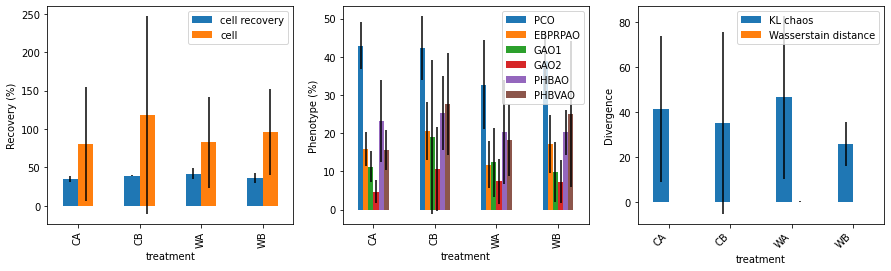

In [13]:
pathin_sum = os.path.join(pathout,"summary.xlsx")
pathout_sum = pathin_sum.replace("summary.xlsx","summary.png")
summary = pd.read_excel(pathin_sum,index_col=0)
fig, ax = Raman_plot.viz_summary(metalevel[0],summary,figsize=(15,4),
                                 plots=[["cell recovery","cell"],\
                                        ["PCO","EBPRPAO","GAO1","GAO2","PHBAO","PHBVAO"],\
                                        ["KL chaos","Wasserstain distance"]],\
                                 labels=["Recovery (%)", "Phenotype (%)", "Divergence"])
fig.savefig(pathout_sum,bbox_inches='tight')

## Basic characterization of Raman Spec
### Average plot
### Molecular distribution

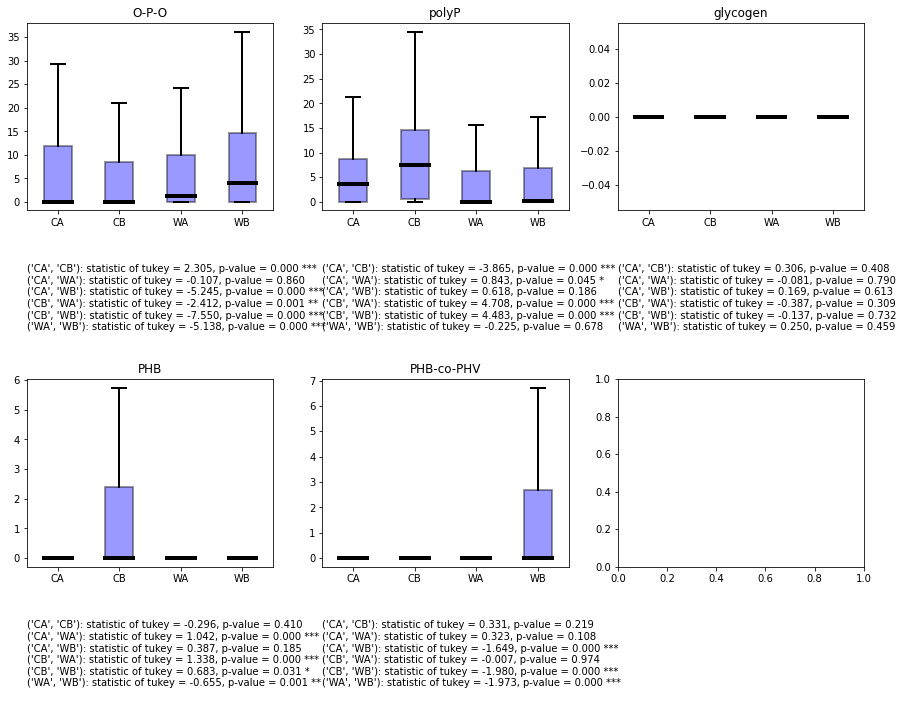

In [34]:
imp.reload(Raman_plot)
# plot the average and molecular distribution given a RamanLevel
metalevel = ['treatment','biological repetitive','repetitive']
RamanLevel = metalevel[0] # you need to determine this based on your metalevel
Ramanpathin = pathin
Ramanpathout = Ramanpathin + "_out/mean_features" # dir to save feature ranking and average images
if not os.path.exists(Ramanpathout):
    os.makedirs(Ramanpathout)
# init
dirs = os.listdir(Ramanpathin)
dirs = [dir for dir in dirs if not dir.startswith(".")]
colorlist = Raman_color.color(len(dirs)).default_c()
speclist = Raman_read.read_txt(Ramanpathin,typpe='dir',dataloop=len(metalevel),metalevel=metalevel,outdir=Ramanpathin+"_out")
PATH_Raman = speclist.groupby(by=RamanLevel)["abspathout"]

all_violin = pd.DataFrame() # to save dataframe to plot all violinplot based on treatment
for group, path in PATH_Raman:
    for i, path_i in enumerate(path):
        # Read the Excel file into a dataframe
        specdata = pd.read_excel(path_i,"cell",index_col=0,header=None) # n x d
        moldata = pd.read_excel(path_i,"molecule",index_col=0) # n x d
        if i == 0: # init
            group_data = specdata 
            group_mol = moldata
        else:
            # combine spec data
            new_X, df1_new, df2_new = Raman_preprocess.binning(group_data.T,specdata.T) # input and ouput is d x n
            group_data = pd.concat([new_X, df1_new.iloc[:,1:], df2_new.iloc[:,1:]],axis=1).T

            # combine mol data
            group_mol = pd.concat([group_mol,moldata],axis=0)
    
    #### spec data
    # # save spec data
    # allspec_save = os.path.join(Ramanpathout,"Raman.mean.%s.csv"%group)
    # group_data.to_csv(allspec_save, index=False,header=False)
    # # plot&save mean of spec data
    # fig, ax = Raman_plot.draw_between(group_data.iloc[0,:],group_data.iloc[1:,],xlim=(380,2000))
    # fig.savefig(allspec_save.replace(".csv",".png"),bbox_inches="tight")
    
    # #### mol data
    # mol_save = os.path.join(Ramanpathout,"Raman.violin.%s.csv"%group)
    # group_mol.to_csv(mol_save,index=False)
    # # plot&save mol data
    # fig2 = Raman_plot.plot_mol(group_mol)
    # pio.write_image(fig2, mol_save.replace(".csv",".png"),scale=3)
    
    temp_group_mol = group_mol.reset_index(names="treatment")
    temp_group_mol["treatment"] = group
    all_violin = pd.concat([all_violin,temp_group_mol],axis=0)

# plot&save partial data
fig_dict = {"starti":1, "endi":"end", "ncols":3,"continuous":"N",
            "allcol":["O-P-O","polyP","glycogen","PHB","PHB-co-PHV"],
            "showfliers":False}
by = "treatment" # if none
fig = Raman_plot.meta_boxplot(all_violin,by,fig_dict,method="tukey")
fig.savefig(os.path.join(Ramanpathout,"Raman.violin.partmol.png"),bbox_inches="tight",dpi=300)


## Raman Feature Ranking

In [ ]:
# check my previous code about biofilm-based feature ranking

## Run OPU Analysis

In [15]:
# prepare dataset config 
# determine OPU file level and OPU path
OPUlevel = metalevel[0] # you need to determine this based on your metalevel
OPUpathin = os.path.join(pathout,"OPU")
OPUpathout = OPUpathin + "_out"
if not os.path.exists(OPUpathout):
    os.makedirs(OPUpathout)

# init
dirs = os.listdir(OPUpathin)
dirs = [dir for dir in dirs if not dir.startswith(".")]
colorlist = Raman_color.color(len(dirs)).default_c()
speclist = Raman_read.read_txt(OPUpathin,typpe='dir',dataloop=len(metalevel),metalevel=metalevel,outdir="./")
# run iteration for config file
dataset_config = []
for i, dir in enumerate(dirs):
    temp_dict = {}
    temp_dict["name"] = dir
    temp_dict["color"] = colorlist[i]
    temp_dict['file'] = speclist.loc[speclist[OPUlevel]==dir, :]["abspath"].tolist()
    
    dataset_config.append(temp_dict)
    
with open(os.path.join(OPUpathout,"dataset_config.json"), "w") as f:
    json.dump(dataset_config, f)

In [18]:
# prepare parameter dictionary
params = {
    "load":{
        "bin_size": 3.0,
        "wavenum_low": 400,
        "wavenum_high": 1800,
        "normalize": "l2"},
    "HCA":{
        "metric": "cosine",
        "cutoff": 0.6,
        "max_n_opus": 0,
        "opu_min_size": 0.02 # fraction of total; lower value -> more OPU
    },
    "save":{
        "dpi": 500,
        "opulabel": os.path.join(OPUpathout,"opu_labels.txt"),
        "opucollection": os.path.join(OPUpathout,"spectra_collection"),
        "plothca":os.path.join(OPUpathout,"HCAplot.png"),
        "plotstackbar":os.path.join(OPUpathout,"stackbar.png"),
        "biplot":os.path.join(OPUpathout,"biplot.png"),
        "featuretable":os.path.join(OPUpathout,"opu.feature_rank.txt"),
        "plotfeaturerank":os.path.join(OPUpathout,"opu.feature_rank.png"),
    },
    
}
with open(os.path.join(OPUpathout,"params_config.json"), "w") as f:
    json.dump(params, f)

In [19]:
# now we can create the OPU analyzer object
opu_analysis = oal.OPUAnalysis.from_config(dataset_config,
	# we also need extra reconcile parameters to tell the program how to
	# preprocess the data, and more importantly, if need binning to force align
	# the wavenumbers in each dataset (as they can be slightly different each
	# run)
	reconcile_param=dict(
		bin_size=params["load"]["bin_size"],  # use bin-size of 5
		wavenum_low=params["load"]["wavenum_low"],  # extract the wavenumber range >= 400
		wavenum_high=params["load"]["wavenum_high"],  # extract the wavenumber range <= 1800
		normalize=params["load"]["normalize"],  # use Euclidean (l2) normalization
	)
)
# run HCA 
opu_analysis.run_hca(metric=params["HCA"]["metric"], cutoff=params["HCA"]["cutoff"],
                     max_n_opus=params["HCA"]["max_n_opus"], opu_min_size=params["HCA"]["opu_min_size"])
# save label
opu_analysis.save_opu_labels(params["save"]["opulabel"], delimiter="\t")
# save spectra data
opu_analysis.save_opu_collections(params["save"]["opucollection"])
# plot HCA
opu_analysis.plot_opu_hca(plot_to=params["save"]["plothca"], dpi=params["save"]["dpi"])
# plot stack barchart
opu_analysis.plot_opu_abundance_stackbar(plot_to=params["save"]["plotstackbar"], dpi=params["save"]["dpi"])
# PCA biplot 
opu_analysis.plot_opu_abundance_biplot(plot_to=params["save"]["biplot"], dpi=params["save"]["dpi"], method="pca")
# feature ranking compute, save, plot
opu_analysis.rank_features("fisher_score")  # 'method=' can be omitted
opu_analysis.save_opu_feature_rank_table(params["save"]["featuretable"], delimiter="\t")
opu_analysis.plot_opu_feature_rank(plot_to=params["save"]["plotfeaturerank"], dpi=params["save"]["dpi"])

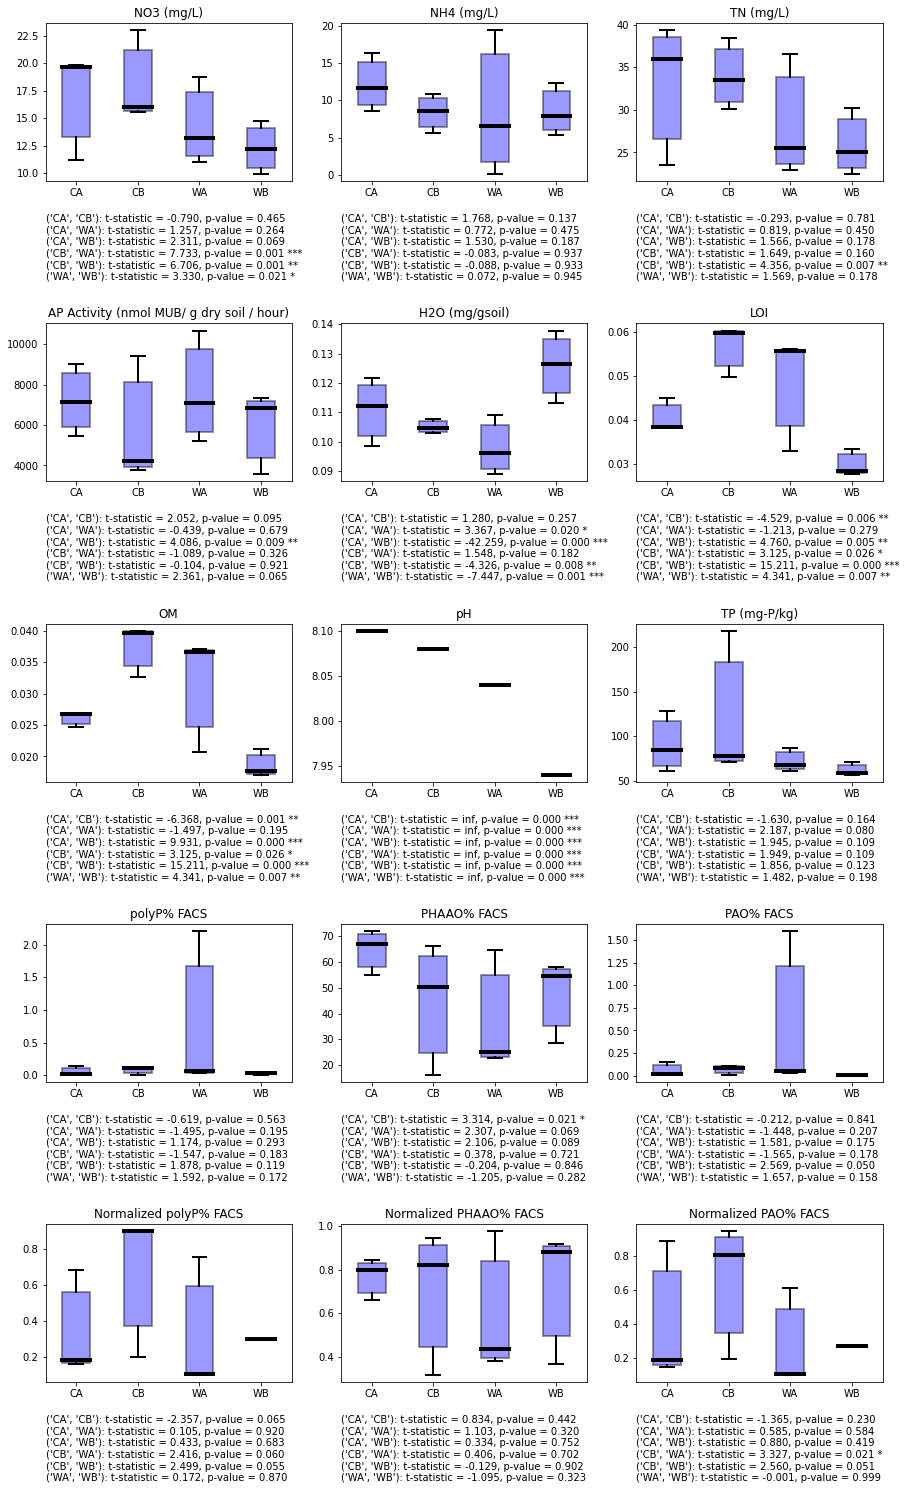

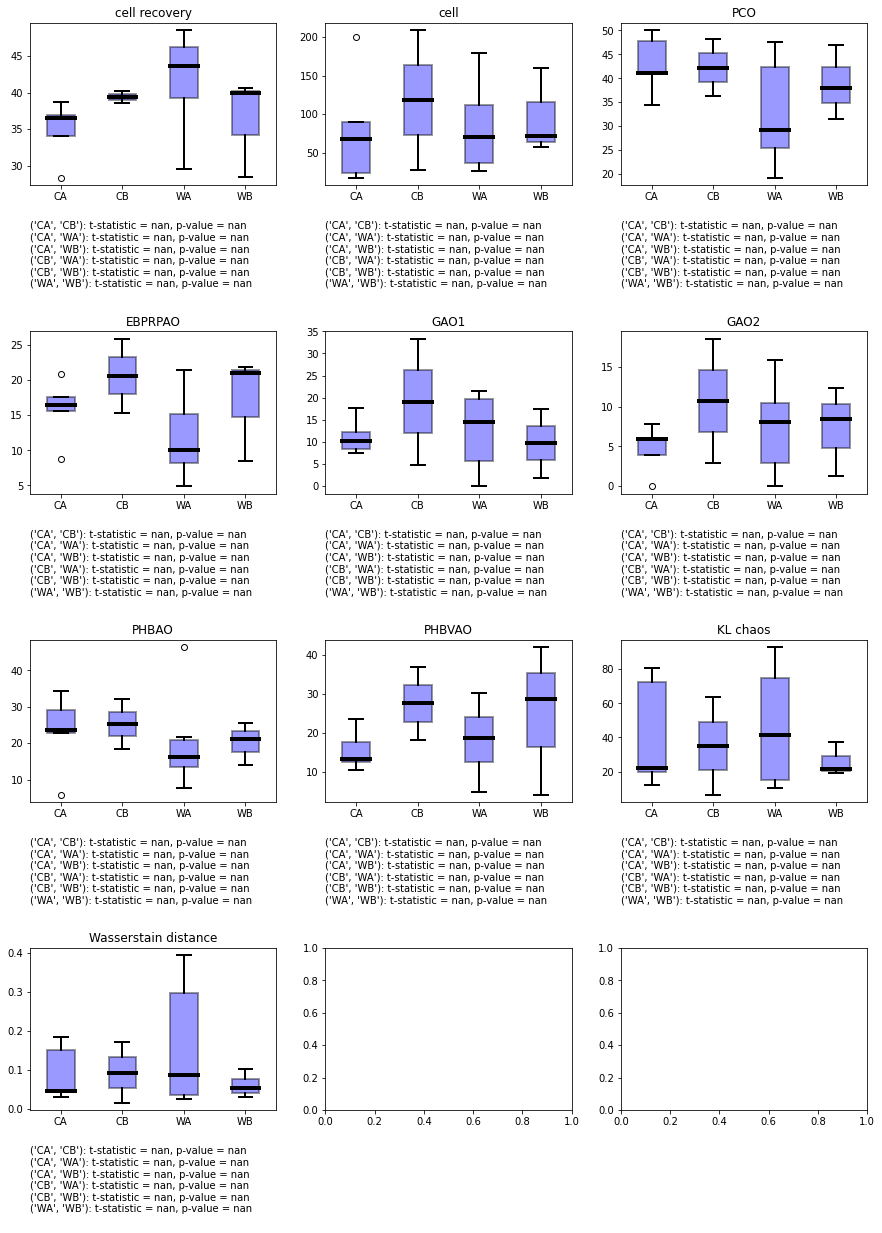

In [185]:
imp.reload(Raman_plot)
# draw the metadata
fig_dict = {"starti":5, "endi":20, "ncols":3,"continuous":"Y"}
metadf = pd.read_excel("/Users/zijianleowang/Desktop/GitHub/EasyMicrobiome/data/ZhouSoil16S/Old/metadata2.xlsx",
                     sheet_name="metadata")
by = "Sample name"
fig = Raman_plot.meta_boxplot(metadf,by,fig_dict)
fig.savefig("/Users/zijianleowang/Downloads/Zhou soil Raman/old/2019_out/metadata.png",bbox_inches="tight",dpi=300)

# draw the summary file
fig_dict = {"starti":7, "endi":"end", "ncols":3,"continuous":"Y"}
metadf = pd.read_excel("/Users/zijianleowang/Downloads/Zhou soil Raman/old/2019_out/summary.xlsx",
                     sheet_name="summary")
by = "treatment"
fig = Raman_plot.meta_boxplot(metadf,by,fig_dict)
fig.savefig("/Users/zijianleowang/Downloads/Zhou soil Raman/old/2019_out/Raman_summary.png",bbox_inches="tight",dpi=300)

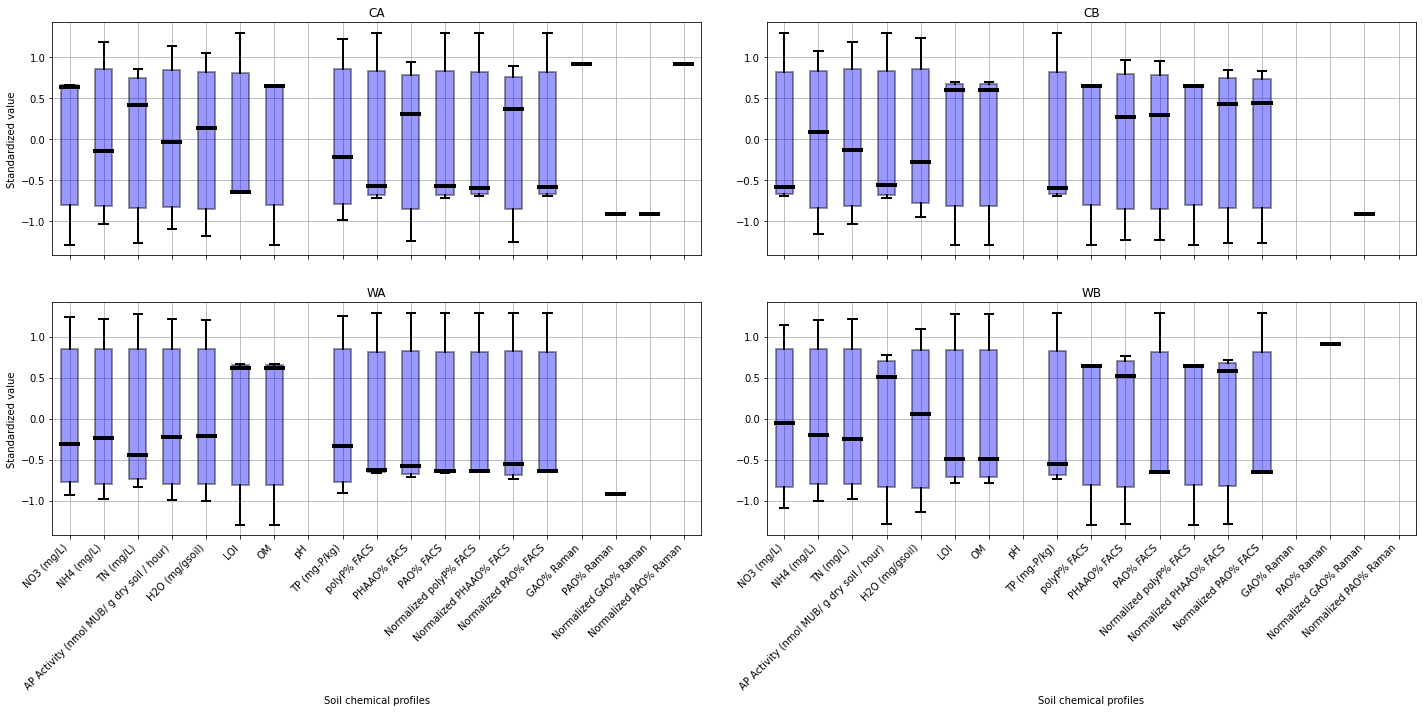

In [167]:
# Group the dataframe by "Sample name"
grouped = metadf.groupby(by="Sample name")

# Create a figure with subplots for each group
ncols=2
nrows=math.ceil(len(grouped)//ncols)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10 * nrows,5*ncols))

col_iter = 5
# Loop over the groups and create a boxplot for each one
for i, (group_name, group_df) in enumerate(grouped):
    ax = group_df.iloc[:,col_iter:].transform(lambda x: (x - x.mean())/x.std()).boxplot(ax=axes[i//ncols, i%ncols],
                                        boxprops={"facecolor":"b","alpha":0.4,"linewidth":2},
                                        whiskerprops={"linewidth":2},
                                        capprops={"linewidth":2},
                                        medianprops={"linewidth":4,"color":"k"},
                                        patch_artist=True)
    ax.set_title(group_name)
    if i %ncols == 0:
        ax.set_ylabel('Standardized value')
    if i//ncols == nrows-1:
        ax.set_xlabel('Soil chemical profiles')
        # set x-label rotation and horizontal alignment
        labels = ax.get_xticklabels()
        plt.setp(labels, rotation=45, ha='right')
    else:
        ax.set_xticklabels([])
# Adjust the layout and spacing of the subplots
fig.tight_layout()
plt.subplots_adjust(hspace=0.2)